In [1]:
import pprint
import re
import string
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import requests_cache
from pymongo import MongoClient
from tqdm.notebook import tqdm


In [2]:
def extract_unique_env_attributes(mongo_uri="mongodb://localhost:27017/", db_name="ncbi_metadata",
                                  input_collection_name="biosample_harmonized_attributes",
                                  output_collection_name="unique_triad_values"):
    """
    Extracts unique values from 'env_broad_scale', 'env_local_scale', and 'env_medium' attributes
    from a MongoDB collection, counts their occurrences, and stores them in a new collection.
    Adds a progress indicator using estimated document count.

    :param mongo_uri: MongoDB connection URI.
    :param db_name: Name of the database.
    :param input_collection_name: Name of the input collection.
    :param output_collection_name: Name of the output collection.
    """

    try:
        client = MongoClient(mongo_uri)
        db = client[db_name]
        input_collection = db[input_collection_name]
        output_collection = db[output_collection_name]

        output_collection.drop()  # Drop the collection

        print(f"Collection '{output_collection_name}' dropped successfully.")

    except Exception as e:
        print(f"An error occurred: {e}")

    try:
        unique_values = {}

        total_count = input_collection.estimated_document_count()
        print(f"{total_count = }")

        with tqdm(total=total_count, desc="Processing Harmonized Biosamples") as pbar:
            for sample in input_collection.find():
                env_broad = sample.get("env_broad_scale")
                env_local = sample.get("env_local_scale")
                env_medium = sample.get("env_medium")

                for value in [env_broad, env_local, env_medium]:
                    if value:
                        if value in unique_values:
                            unique_values[value]["count"] += 1
                        else:
                            unique_values[value] = {"content": value, "count": 1}
                pbar.update(1)

        # Insert unique values into the new collection
        output_collection.insert_many(list(unique_values.values()))

        print(
            f"Extracted and counted unique environment attributes from '{input_collection_name}' to '{output_collection_name}'.")

    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'client' in locals() and client:
            client.close()


In [3]:
def display_count_distribution(mongo_uri="mongodb://localhost:27017/", db_name="ncbi_metadata",
                               collection_name="unique_triad_values"):
    """
    Retrieves counts from a MongoDB collection and displays their distribution as a histogram.

    :param mongo_uri: MongoDB connection URI.
    :param db_name: Name of the database.
    :param collection_name: Name of the collection containing counts.
    """
    try:
        client = MongoClient(mongo_uri)
        db = client[db_name]
        collection = db[collection_name]

        counts = [doc["count"] for doc in collection.find({}, {"count": 1, "_id": 0})]  # get all counts

        if not counts:
            print("No counts found in the collection.")
            return

        plt.figure(figsize=(10, 6))
        plt.hist(counts, bins=np.logspace(np.log10(min(counts)), np.log10(max(counts)), 50),
                 log=True)  # use log scale and logspace for bins.
        plt.xscale('log')
        plt.title("Distribution of Counts")
        plt.xlabel("Count (log scale)")
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'client' in locals() and client:
            client.close()



In [4]:
def normalize_string(s):
    """
    Normalizes a string by lowercasing, trimming, and removing duplicate whitespace.
    """
    if not isinstance(s, str):
        return ""  # handle non string input.
    s = s.lower()
    s = s.strip()
    s = re.sub(r'\s+', ' ', s)  # Replace multiple whitespace with single space
    return s

In [5]:
def assess_normalization_impact(mongo_uri="mongodb://localhost:27017/", db_name="ncbi_metadata",
                                collection_name="unique_triad_values",
                                fields_to_normalize=["content"]):
    """
    Assesses the impact of string normalization on specified fields in a MongoDB collection.

    :param mongo_uri: MongoDB connection URI.
    :param db_name: Name of the database.
    :param collection_name: Name of the collection.
    :param fields_to_normalize: List of fields to normalize and assess.
    """
    try:
        client = MongoClient(mongo_uri)
        db = client[db_name]
        collection = db[collection_name]

        original_unique_counts = {}
        normalized_unique_counts = {}

        for field in fields_to_normalize:
            original_unique_values = set()
            normalized_unique_values = set()

            for doc in collection.find({field: {"$ne": None}}, {field: 1, "_id": 0}):
                original_value = doc.get(field)
                if isinstance(original_value, str):
                    original_unique_values.add(original_value)
                    normalized_value = normalize_string(original_value)
                    normalized_unique_values.add(normalized_value)

            original_unique_counts[field] = len(original_unique_values)
            normalized_unique_counts[field] = len(normalized_unique_values)

        print("Unique value counts before normalization:")
        for field, count in original_unique_counts.items():
            print(f"  {field}: {count}")

        print("\nUnique value counts after normalization:")
        for field, count in normalized_unique_counts.items():
            print(f"  {field}: {count}")

        print("\nReduction in unique values:")
        for field in fields_to_normalize:
            reduction = original_unique_counts[field] - normalized_unique_counts[field]
            percentage_reduction = (reduction / original_unique_counts[field]) * 100 if original_unique_counts[
                                                                                            field] > 0 else 0
            print(f"  {field}: {reduction} ({percentage_reduction:.2f}%)")

    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'client' in locals() and client:
            client.close()


In [6]:
def find_envo_values(mongo_uri="mongodb://localhost:27017/", db_name="ncbi_metadata",
                     collection_name="unique_triad_values"):
    """
    Finds all content values containing "envo" (case-insensitive) in a MongoDB collection.

    :param mongo_uri: MongoDB connection URI.
    :param db_name: Name of the database.
    :param collection_name: Name of the collection.
    :return: A list of content values containing "envo".
    """
    try:
        client = MongoClient(mongo_uri)
        db = client[db_name]
        collection = db[collection_name]

        envo_values = []
        for doc in collection.find():
            content = doc.get("content", "")
            if "envo" in content.lower():
                envo_values.append(content)

        return envo_values

    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'client' in locals() and client:
            client.close()


In [7]:
def dump_list_to_file(string_list, filename):
  """
  Dumps a list of strings to a text file, one item per line.

  Args:
    string_list: The list of strings to dump.
    filename: The name of the file to create or overwrite.
  """
  with open(filename, 'w') as f:
    for item in string_list:
      f.write(item + '\n')


In [8]:
def repair_curie(raw_curie: str) -> str:
    """
    Attempt to normalize or 'repair' the CURIE-like string:
      1. Normalize namespace to uppercase if it looks like 'ENVO'.
      2. Replace underscores or periods with a colon (':') between prefix & ID.
      3. Strip extra whitespace around the ID.
    """
    curie = raw_curie.strip()

    # Attempt to split at the first occurrence of [.:_]
    match = re.match(r'^([A-Za-z0-9]+)([\.:_])\s*(.*)$', curie)
    if not match:
        # If it doesn't match, just return the stripped version
        return curie

    prefix, sep, rest = match.groups()

    # Rebuild as prefix:rest with no extra spaces
    repaired = f"{prefix}:{rest.strip()}"
    return repaired

In [9]:
def split_annotations(raw_content: str):
    """
    Split a single raw line into sub-annotations, returning a list of dicts:
      [
         {
           'raw_chunk': "...",         # substring after splitting
           'raw_curie': "...",         # curie as found in text (if any)
           'repaired_curie': "...",    # normalized curie (if any)
           'raw_label': "...",         # substring minus the matched curie portion
           'cleaned_label': "..."      # lowercased + extra whitespace removed
         },
         ...
      ]
    """
    # Split on major delimiters (pipe, semicolon, slash, comma)
    components = re.split(DELIMITERS, raw_content)

    results = []
    for component in components:
        component = component.strip()
        if not component:
            continue

        match = CURIE_PATTERN.search(component)
        if match:
            raw_curie = match.group(1)
            repaired = repair_curie(raw_curie)

            # Remove the matched substring from the chunk to guess the label
            label_guess = component[:match.start()] + component[match.end():]
            # Also remove leftover brackets or parentheses
            label_guess = re.sub(r'[\(\)\[\]]+', ' ', label_guess).strip()

            cleaned_label = re.sub(f"[{re.escape(string.punctuation)}]", " ", label_guess.lower())
            cleaned_label = re.sub(f"\d+", " ", cleaned_label)
            cleaned_label = re.sub(r'\s+', ' ', cleaned_label.strip())

        else:
            # No curie found; treat entire chunk as label
            raw_curie = ''
            repaired = ''
            cleaned_label = re.sub(f"[{re.escape(string.punctuation)}]", " ", component.lower())
            cleaned_label = re.sub(f"\d+", " ", cleaned_label)
            cleaned_label = re.sub(r'\s+', ' ', cleaned_label.strip())
            label_guess = component

        results.append({
            'raw_component': component,
            'raw_curie': raw_curie,
            'repaired_curie': repaired,
            'repaired_prefix': repaired.split(":")[0],
            'raw_label': label_guess,
            'cleaned_label': cleaned_label,
            'cleaned_label_len': len(cleaned_label),
        })

    return results

In [10]:
# Function to get a random document by repaired prefix
def get_random_by_repaired_prefix(prefix):
    result = triad_values_collection.aggregate([
        {"$match": {"parsed_annotations.repaired_prefix": prefix}},
        {"$sample": {"size": 1}}
    ])
    return list(result)  # Convert cursor to list for easy access

In [11]:
# Function to get a random document by annotations count
def get_random_by_annotations_count(count):
    result = triad_values_collection.aggregate([
        {"$match": {"annotations_count": count}},
        {"$sample": {"size": 1}}
    ])
    return list(result)  # Convert cursor to list for easy access

In [12]:
def analyze_ontology_importance(ontology_matches):
    # Step 1: Compute term frequencies across all ontologies
    term_counts = Counter()
    for terms in ontology_matches.values():
        term_counts.update(terms)

    # Step 2: Identify unique terms and count them per ontology
    unique_terms_per_ontology = defaultdict(set)
    unique_counts_per_ontology = {}

    for ontology, terms in ontology_matches.items():
        unique_terms = {term for term in terms if term_counts[term] == 1}
        unique_terms_per_ontology[ontology] = unique_terms
        unique_counts_per_ontology[ontology] = len(unique_terms)

    # Step 3: Sort ontologies by unique term count in descending order
    ranked_ontologies = sorted(unique_counts_per_ontology.items(), key=lambda x: x[1], reverse=True)

    return ranked_ontologies, dict(unique_terms_per_ontology)  # Ensure it returns a dictionary, not defaultdict


In [13]:
# Example usage (assuming MongoDB is running locally)
extract_unique_env_attributes()

Collection 'unique_triad_values' dropped successfully.
total_count = 43169967


Processing Harmonized Biosamples:   0%|          | 0/43169967 [00:00<?, ?it/s]

Extracted and counted unique environment attributes from 'biosample_harmonized_attributes' to 'unique_triad_values'.


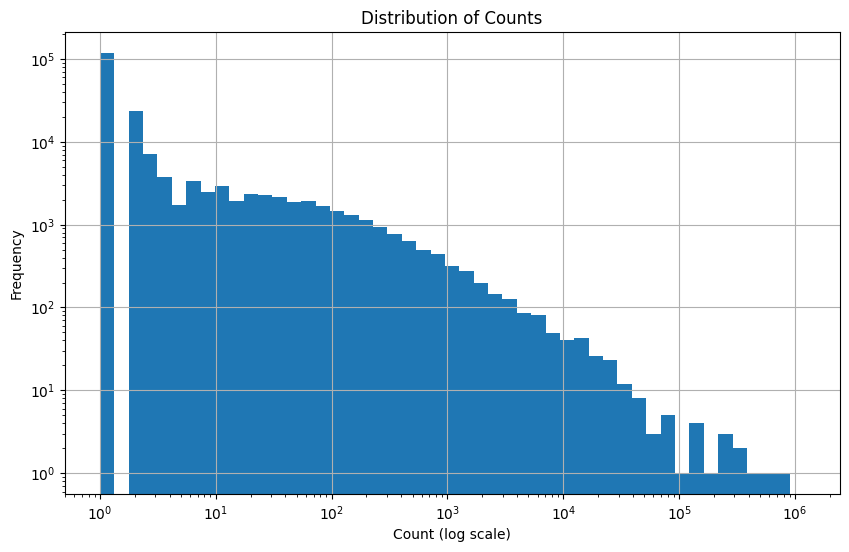

In [14]:
# Example usage (assuming MongoDB is running locally)
display_count_distribution()

## There are limits to the usefulness of premature normalization

In [15]:
# Example usage:
assess_normalization_impact()

Unique value counts before normalization:
  content: 185144

Unique value counts after normalization:
  content: 178669

Reduction in unique values:
  content: 6475 (3.50%)


----

## For analyzing with LLMs etc.

In [16]:
# Example usage:
envo_values = find_envo_values()


In [17]:
print(len(envo_values))

28091


In [18]:
dump_list_to_file(envo_values, "triad_values_containing_envo.txt")

----

In [19]:
# Regex to find potential CURIEs, optionally bracketed or parenthesized
# e.g., (ENVO:00000446), [EnvO_00005774], (envo.123456), etc.
CURIE_PATTERN = re.compile(
    r'[\(\[\s]*([A-Za-z0-9]+[\.:_]\s*[0-9A-Za-z]+)\s*[\)\]\s]*',
    flags=re.IGNORECASE
)

In [20]:
# We consider these delimiters for splitting multiple annotations in one value
DELIMITERS = r'[|;,/]+'

In [21]:
# Connect to local MongoDB on default port
client = MongoClient('mongodb://localhost:27017')


In [22]:
# Access the database and the collections
db = client.ncbi_metadata
triad_values_collection = db.unique_triad_values


In [23]:
# For each document in unique_triad_values, parse and upsert into unique_triad_values
# it appears that content and original_content are always the same
for doc in triad_values_collection.find():
    original_content = doc.get("content", "")
    parsed_annotations = split_annotations(original_content)

    # Create the update document
    new_doc = {
        "content_len": len(original_content),
        "formula_like": original_content.startswith("="),
        "parsed_annotations": parsed_annotations,
        "annotations_count": len(parsed_annotations),
    }

    # Upsert (update if exists, insert if not)
    triad_values_collection.update_one(
        {"_id": doc["_id"]},  # Match by original document ID
        {"$set": new_doc},    # Update fields
        upsert=True           # Insert if doesn't exist
    )

print("Done! Upserted parsed triad annotations.")

# ~ 1 minute


Done! Upserted parsed triad annotations.


In [24]:
all_annotations = triad_values_collection.find({}, {"parsed_annotations.repaired_prefix": 1})

repaired_prefix_list = [
    annotation["repaired_prefix"]
    for doc in all_annotations
    for annotation in doc.get("parsed_annotations", [])
    if annotation["repaired_prefix"]  # Exclude empty values
]

prefix_counts = Counter(repaired_prefix_list)

# Convert to a DataFrame
prefix_count_frame = pd.DataFrame(prefix_counts.items(), columns=["repaired_prefix", "Count"])
prefix_count_frame = prefix_count_frame.sort_values(by="Count", ascending=False)


In [25]:
prefix_count_frame

,repaired_prefix,Count
0,ENVO,35491
9,UBERON,2054
130,BTO,2024
271,sample,1796
5,PO,1381
...,...,...
5172,W25,1
19,Fallow,1
12,hydrothermal,1
7,rhizospheric,1


In [26]:
# Retrieve all annotation count values
all_counts = triad_values_collection.find({}, {"annotations_count": 1})

# Extract annotation counts into a list
annotation_count_list = [
    doc.get("annotations_count", 0) for doc in all_counts
]

# Count occurrences of each annotation count value
annotation_count_distribution = Counter(annotation_count_list)

# Convert to a DataFrame
annotation_count_frame = pd.DataFrame(
    annotation_count_distribution.items(), columns=["Annotations Count", "Frequency"]
)
annotation_count_frame = annotation_count_frame.sort_values(by="Annotations Count", ascending=True)



In [27]:
annotation_count_frame

,Annotations Count,Frequency
12,0,1
0,1,168601
1,2,6668
2,3,3810
4,4,2425
3,5,2590
5,6,299
7,7,26
10,8,7
13,9,1


In [28]:
# Ensure indexes exist for efficient querying
triad_values_collection.create_index([("content", 1)])


'content_1'

In [29]:
triad_values_collection.create_index([("count", 1)])

'count_1'

In [30]:
triad_values_collection.create_index([("annotations_count", 1)])

'annotations_count_1'

In [31]:
triad_values_collection.create_index([("content_len", 1)])

'content_len_1'

In [32]:
triad_values_collection.create_index([("formula_like", 1)])

'formula_like_1'

In [33]:
triad_values_collection.create_index([("parsed_annotations.raw_component", 1)])

'parsed_annotations.raw_component_1'

In [34]:
triad_values_collection.create_index([("parsed_annotations.raw_curie", 1)])

'parsed_annotations.raw_curie_1'

In [35]:
triad_values_collection.create_index([("parsed_annotations.repaired_curie", 1)])

'parsed_annotations.repaired_curie_1'

In [36]:
triad_values_collection.create_index([("parsed_annotations.repaired_prefix", 1)])

'parsed_annotations.repaired_prefix_1'

In [37]:
triad_values_collection.create_index([("parsed_annotations.raw_label", 1)])


'parsed_annotations.raw_label_1'

In [38]:
triad_values_collection.create_index([("parsed_annotations.cleaned_label", 1)])

'parsed_annotations.cleaned_label_1'

In [39]:
triad_values_collection.create_index([("parsed_annotations.cleaned_label_len", 1)])

'parsed_annotations.cleaned_label_len_1'

In [40]:
random_prefix_sample = get_random_by_repaired_prefix("ENVO")  # Replace "ENVO" with desired prefix


In [41]:
pprint.pprint(random_prefix_sample)

[{'_id': ObjectId('67c768da06528f8953e812f3'),
  'annotations_count': 1,
  'content': 'ENVO:01000324',
  'content_len': 13,
  'count': 5,
  'formula_like': False,
  'parsed_annotations': [{'cleaned_label': '',
                          'cleaned_label_len': 0,
                          'raw_component': 'ENVO:01000324',
                          'raw_curie': 'ENVO:01000324',
                          'raw_label': '',
                          'repaired_curie': 'ENVO:01000324',
                          'repaired_prefix': 'ENVO'}]}]


In [42]:
random_count_sample = get_random_by_annotations_count(3)  # Replace 3 with desired count

In [43]:
pprint.pprint(random_count_sample)

[{'_id': ObjectId('67c768da06528f8953e87d45'),
  'annotations_count': 3,
  'content': '=IF(L60>29.5,"Mesophotic","Shallow")',
  'content_len': 36,
  'count': 1,
  'formula_like': True,
  'parsed_annotations': [{'cleaned_label': 'if l',
                          'cleaned_label_len': 4,
                          'raw_component': '=IF(L60>29.5',
                          'raw_curie': '29.5',
                          'raw_label': '=IF L60>',
                          'repaired_curie': '29:5',
                          'repaired_prefix': '29'},
                         {'cleaned_label': 'mesophotic',
                          'cleaned_label_len': 10,
                          'raw_component': '"Mesophotic"',
                          'raw_curie': '',
                          'raw_label': '"Mesophotic"',
                          'repaired_curie': '',
                          'repaired_prefix': ''},
                         {'cleaned_label': 'shallow',
                          'cleaned_l

In [44]:
# Retrieve all parsed annotations along with their counts
all_annotations = triad_values_collection.find({}, {"parsed_annotations.cleaned_label": 1, "count": 1})

# Dictionary to store cumulative counts for each cleaned_label
cleaned_label_counts = Counter()

# Iterate through each document and sum up counts per cleaned_label
for doc in all_annotations:
    doc_count = doc.get("count", 1)  # Default count to 1 if missing (to avoid KeyErrors)

    for annotation in doc.get("parsed_annotations", []):
        cleaned_label = annotation.get("cleaned_label")
        if cleaned_label:  # Ensure it's not empty
            cleaned_label_counts[cleaned_label] += doc_count  # Sum based on document count


In [45]:
collection = db['triad_components_labels']

# Convert Counter to a list of dictionaries
component_label_counts = [{"component_label": key, "count": count} for key, count in cleaned_label_counts.items()]

In [46]:
component_label_count_values = [i['count'] for i in component_label_counts]

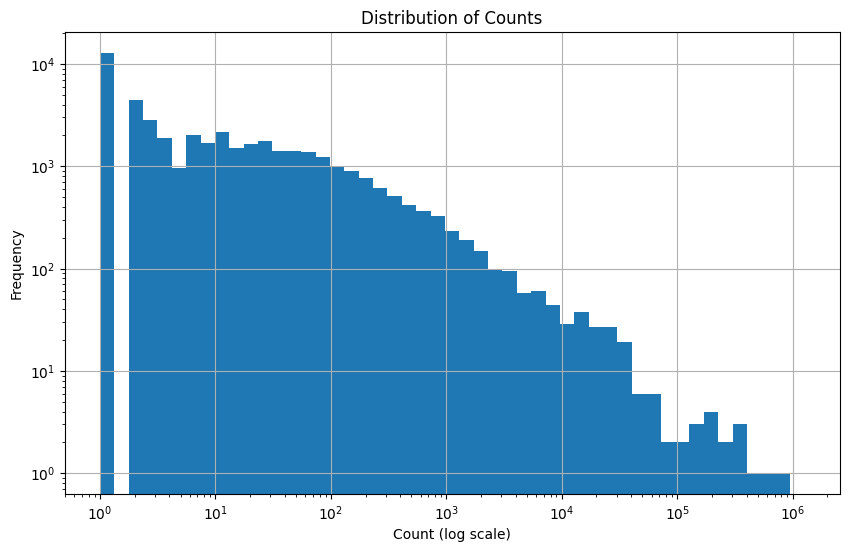

In [47]:
plt.figure(figsize=(10, 6))
plt.hist(component_label_count_values,
         bins=np.logspace(np.log10(min(component_label_count_values)), np.log10(max(component_label_count_values)), 50),
         log=True)  # use log scale and logspace for bins.
plt.xscale('log')
plt.title("Distribution of Counts")
plt.xlabel("Count (log scale)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()



In [48]:
# Insert all records at once
if component_label_counts:
    collection.insert_many(component_label_counts)
    print("Inserted records successfully!")

Inserted records successfully!


In [49]:
# Convert to a DataFrame
df_cleaned_label_counts = pd.DataFrame(cleaned_label_counts.items(), columns=["Cleaned Label", "Count"])
df_cleaned_label_counts = df_cleaned_label_counts.sort_values(by="Count", ascending=False)

In [50]:
df_cleaned_label_counts

,Cleaned Label,Count
140,not applicable,1264549
43,missing,840902
23,feces,607026
1,human associated habitat,471324
103,human gut,376855
...,...,...
7577,root canal scraping,1
7576,infected tooth root canal,1
7575,liver abcess material,1
7574,liver abcess,1


In [51]:
# Define threshold
COMPONENT_COUNT_THRESHOLD = 2 # Set threshold as needed
MIN_LABEL_LEN = 3

In [52]:
# Database collection
collection = db["triad_components_labels"]

In [53]:
# OLS Search API URL
OLS_SEARCH_URL = "https://www.ebi.ac.uk/ols/api/search"

In [54]:
# Ontologies to search
ONTOLOGIES = "envo,ncit,ncbitaxon,uberon,snomed,foodon,micro,genepio,po,obi,ohmi,agro,pco,gsso,exo,mco,vbo,pato,edam"

In [55]:
# Fetch documents that meet the threshold
# oops should have done greater than or equal to
docs = list(collection.find({"count": {"$gt": COMPONENT_COUNT_THRESHOLD}}, {"component_label": 1}))


In [56]:
# Enable request caching
requests_cache.install_cache("ols_cache", expire_after=86400)  # Cache expires after 1 day

In [57]:
# Iterate over documents with tqdm for progress tracking
for doc in tqdm(docs, desc="Processing components", unit="doc"):
    query = doc.get("component_label", "").strip().lower()
    if len(query) < MIN_LABEL_LEN:
        continue  # Skip short labels

    start = 0  # Start pagination at 0
    rows = 1000  # Max per request (set to 100 for efficiency)
    ols_hits = []  # Store matching results

    while True:
        params = {
            "q": query,
            "exact": "true",
            "fieldList": "ontology_name,is_defining_ontology,obo_id,label",
            "ontology": ONTOLOGIES,
            "queryFields": "label,synonym",
            "rows": rows,
            "start": start,
        }

        response = requests.get(OLS_SEARCH_URL, params=params)
        response.raise_for_status()
        data = response.json()

        # Extract results
        results = data.get("response", {}).get("docs", [])

        # If no results, break loop
        if not results:
            break

        # Process results
        for result in results:
            if result.get("is_defining_ontology", False):
                label_lower = result.get("label", "").lower()
                label_lower_match = label_lower == query
                ols_hits.append({
                    "exact_something_match": True,
                    "exact_label_match": label_lower_match,
                    "label": result.get("label", ""),
                    "obo_id": result.get("obo_id", ""),
                    "ontology": result.get("ontology_name", ""),
                })

        # Check if we need to fetch more results
        num_found = data.get("response", {}).get("numFound", 0)
        start += rows  # Move to the next page

        if start >= num_found:  # Stop if we've retrieved all records
            break

    # Update the document with OLS hits if any
    if ols_hits:
        collection.update_one({"_id": doc["_id"]}, {"$set": {"ols_hits": ols_hits}})

# 4 hours
#   count>=2,
#   ONTOLOGIES = "envo,ncit,ncbitaxon,uberon,snomed,foodon,micro,genepio,po,obi,ohmi,agro,pco,gsso,exo,mco,vbo,pato,edam"
#         params = {
#             "q": query,
#             "exact": "true",
#             "fieldList": "ontology_name,is_defining_ontology,obo_id,label",
#             "ontology": ONTOLOGIES,
#             "queryFields": "label,synonym",
#             "rows": rows,
#             "start": start,
#         }

Processing components:   0%|          | 0/27913 [00:00<?, ?doc/s]

In [58]:
# Ensure indexes exist for efficient querying
collection.create_index([("component_label", 1)])

'component_label_1'

In [59]:
collection.create_index([("count", 1)])

'count_1'

In [60]:
collection.create_index([("ols_hits.exact_something_match", 1)])

'ols_hits.exact_something_match_1'

In [61]:
collection.create_index([("ols_hits.exact_label_match", 1)])

'ols_hits.exact_label_match_1'

In [62]:
collection.create_index([("ols_hits.label", 1)])

'ols_hits.label_1'

In [63]:
collection.create_index([("ols_hits.obo_id", 1)])

'ols_hits.obo_id_1'

In [64]:
collection.create_index([("ols_hits.ontology", 1)])

'ols_hits.ontology_1'

----

## For determining which ontologies to include in the OAK annotation process
or just trust `prefix_count_frame`?

enhance that by checking `id` in https://raw.githubusercontent.com/OBOFoundry/OBOFoundry.github.io/refs/heads/master/registry/ontologies.yml

will have to normalize cases

In [65]:
# # Specify the path to your .env file
# env_path = "../../../local/.env"
# # Load variables into a dictionary
# env_vars = dotenv_values(env_path)
# BIOPORTAL_API_KEY = env_vars['BIOPORTAL_API_KEY']

In [66]:
# BIOPORTAL_SEARCH_URL = "https://data.bioontology.org/search"

In [67]:
# BIOPORTAL_PAGE_SIZE = 100

In [68]:
# # Counter to store occurrences of each ontology
# ontology_counter = Counter()
#
# # Iterate over each query
# for query in queries:
#     print(f"\nSearching for: {query}")
#     page = 1  # Start from page 1
#
#     while True:  # Keep iterating until there are no more pages
#         params = {
#             "q": query,
#             "apikey": BIOPORTAL_API_KEY,
#             "page": page,
#             "pagesize": BIOPORTAL_PAGE_SIZE,
#             "require_exact_match": True
#         }
#
#         # Build the full URL
#         request = requests.Request('GET', BIOPORTAL_SEARCH_URL, params=params)
#         prepared = request.prepare()
#
#         # Print the full URL
#         print(prepared.url)
#
#         # Now make the actual request
#         response = requests.get(BIOPORTAL_SEARCH_URL, params=params)
#
#         if response.status_code == 200:
#             data = response.json()
#             if "collection" not in data or not data["collection"]:
#                 break  # No more results
#
#             for result in data["collection"]:
#                 ontology = result["links"]["ontology"]
#                 ontology_counter[ontology] += 1  # Increment count for this ontology
#
#             # Check if there is a next page
#             if "nextPage" in data["links"]:
#                 page += 1  # Move to the next page
#                 print(f"{page = }")
#             else:
#                 break  # No more pages
#         else:
#             print(f"Error for query '{query}', page {page}: {response.status_code} {response.text}")
#             break  # Exit loop on error
#


In [69]:
# ontology_hit_counts = {k:len(v) for k,v in ontology_matches.items()}

In [70]:
# ontology_hit_counts = dict(sorted(ontology_hit_counts.items(), key=lambda item: item[1], reverse=True))

In [71]:
# # Invert the mapping
# query_matches = defaultdict(set)
# for ontology, classes in ontology_matches.items():
#     for cls in classes:
#         query_matches[cls].add(ontology)

In [72]:
def analyze_ontology_importance_from_mongo(db_name, collection_name, mongo_uri="mongodb://localhost:27017/"):
    # Connect to MongoDB
    client = MongoClient(mongo_uri)
    db = client[db_name]
    collection = db[collection_name]

    ontology_matches = defaultdict(set)

    for doc in collection.find():
        component_label = doc["component_label"]
        ols_hits = doc.get("ols_hits", [])

        for hit in ols_hits:
            ontology = hit["ontology"]
            ontology_matches[ontology].add(component_label)

    return dict(ontology_matches)

In [73]:
hits_by_ontology = analyze_ontology_importance_from_mongo(
    db_name="ncbi_metadata",
    collection_name="triad_components_labels"
)

In [74]:
hits_by_ontology

{'envo': {'stainless steel',
  'dust',
  'anchialine cave',
  'oil well',
  'limestone pavement',
  'alluvial soil',
  'mediterranean sea biome',
  'fluvial island',
  'flooding',
  'lava tube',
  'terrace',
  'high tide zone',
  'cave floor',
  'dune',
  'climate change',
  'agricultural terrace',
  'acid rain',
  'human settlement',
  'river water',
  'interstitial water',
  'underground water body',
  'sedimentation in a water body',
  'polytunnel',
  'arable soil',
  'air filter',
  'sugarcane bagasse',
  'cave system',
  'pinyon juniper woodland',
  'tunnel',
  'glacial process',
  'plaster',
  'acidic hot spring',
  'mesotrophic lake',
  'waste treatment plant',
  'tropical rainforest biome',
  'spruce forest soil',
  'biofilm',
  'sea bottom',
  'drinking water pipeline network',
  'alkaline hot spring',
  'anthrosol',
  'marine supralittoral zone',
  'urban flooding',
  'intermittent estuary',
  'indoor toilet',
  'stock',
  'upland soil',
  'tropical grassland',
  'rice paddy 

In [75]:
def invert_hits_by_ontology(hits_by_ontology):
    labels_to_ontologies = defaultdict(set)

    for ontology, labels in hits_by_ontology.items():
        for label in labels:
            labels_to_ontologies[label].add(ontology)

    return dict(labels_to_ontologies)


In [76]:
hits_by_component_label = invert_hits_by_ontology(hits_by_ontology)

In [77]:
hits_by_component_label

{'stainless steel': {'envo'},
 'dust': {'envo', 'ncit', 'snomed'},
 'anchialine cave': {'envo'},
 'oil well': {'envo', 'snomed'},
 'limestone pavement': {'envo'},
 'alluvial soil': {'envo'},
 'mediterranean sea biome': {'envo'},
 'fluvial island': {'envo'},
 'flooding': {'envo'},
 'lava tube': {'envo'},
 'terrace': {'envo'},
 'high tide zone': {'envo'},
 'cave floor': {'envo'},
 'dune': {'envo'},
 'climate change': {'envo', 'exo'},
 'agricultural terrace': {'envo'},
 'acid rain': {'envo', 'exo'},
 'human settlement': {'envo'},
 'river water': {'envo', 'snomed'},
 'interstitial water': {'envo'},
 'underground water body': {'envo'},
 'sedimentation in a water body': {'envo'},
 'polytunnel': {'envo'},
 'arable soil': {'envo'},
 'air filter': {'envo', 'snomed'},
 'sugarcane bagasse': {'envo'},
 'cave system': {'envo'},
 'pinyon juniper woodland': {'envo'},
 'tunnel': {'envo', 'snomed'},
 'glacial process': {'envo'},
 'plaster': {'envo', 'ncit', 'snomed'},
 'acidic hot spring': {'envo'},
 '

In [78]:
def find_exclusive_hits(hits_by_component_label):
    exclusive_hits = defaultdict(set)

    for component_label, ontologies in hits_by_component_label.items():
        if len(ontologies) == 1:  # If the label is found in only one ontology
            ontology = next(iter(ontologies))  # Get the single ontology
            exclusive_hits[ontology].add(component_label)

    return dict(exclusive_hits)

In [79]:
exclusive_hits_by_ontology = find_exclusive_hits(hits_by_component_label)


In [80]:
exclusive_hits_by_ontology

{'envo': {'stainless steel',
  'anchialine cave',
  'limestone pavement',
  'alluvial soil',
  'mediterranean sea biome',
  'fluvial island',
  'flooding',
  'lava tube',
  'terrace',
  'high tide zone',
  'cave floor',
  'dune',
  'agricultural terrace',
  'human settlement',
  'interstitial water',
  'underground water body',
  'sedimentation in a water body',
  'polytunnel',
  'arable soil',
  'sugarcane bagasse',
  'cave system',
  'pinyon juniper woodland',
  'glacial process',
  'acidic hot spring',
  'mesotrophic lake',
  'waste treatment plant',
  'tropical rainforest biome',
  'spruce forest soil',
  'biofilm',
  'sea bottom',
  'drinking water pipeline network',
  'alkaline hot spring',
  'anthrosol',
  'marine supralittoral zone',
  'urban flooding',
  'intermittent estuary',
  'indoor toilet',
  'upland soil',
  'tropical grassland',
  'rice paddy soil',
  'freshwater lake biome',
  'mesoscale marine eddy',
  'subtropical dry broadleaf forest',
  'organic material',
  'mari

In [81]:
def count_exclusive_hits(exclusive_hits_by_ontology):
    exclusive_hit_counts = {ontology: len(labels) for ontology, labels in exclusive_hits_by_ontology.items()}
    sorted_exclusive_hit_counts = dict(sorted(exclusive_hit_counts.items(), key=lambda x: x[1], reverse=True))
    return sorted_exclusive_hit_counts


In [82]:
exclusive_hit_counts = count_exclusive_hits(exclusive_hits_by_ontology)



display the number of unique hits per target ontology

In [83]:
exclusive_hit_counts

{'envo': 1502,
 'ncit': 601,
 'ncbitaxon': 293,
 'uberon': 218,
 'snomed': 193,
 'foodon': 152,
 'vbo': 33,
 'po': 27,
 'micro': 26,
 'agro': 24,
 'pato': 19,
 'obi': 15,
 'gsso': 14,
 'genepio': 7,
 'pco': 6,
 'mco': 6,
 'edam': 5,
 'ohmi': 5,
 'exo': 3}

In [84]:
COMPONENT_COUNT_THRESHOLD

2

In [85]:
exclusive_hits_by_ontology['obi']

{'cell culture supernatant',
 'cotton swab',
 'cultured cell population',
 'dna extract',
 'illumina miseq',
 'laboratory animal care',
 'lower respiratory tract specimen',
 'nucleic acid extract',
 'ovitrap',
 'pool of specimens',
 'processed material',
 'specimen collection process',
 'specimen from organism',
 'vagina swab specimen',
 'washing'}

In [86]:
collection

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'ncbi_metadata'), 'triad_components_labels')

In [87]:
# Aggregation query
pipeline = [
    {
        "$project": {
            "_id": 0,
            "component_label": 1,
            "count": 1,
            "exact_something_match_count": {
                "$size": {
                    "$filter": {
                        "input": { "$ifNull": ["$ols_hits", []] },  # Ensure ols_hits is always an array
                        "as": "hit",
                        "cond": {"$eq": ["$$hit.exact_something_match", True]}
                    }
                }
            },
            "exact_label_match_count": {
                "$size": {
                    "$filter": {
                        "input": { "$ifNull": ["$ols_hits", []] },  # Ensure ols_hits is always an array
                        "as": "hit",
                        "cond": {"$eq": ["$$hit.exact_label_match", True]}
                    }
                }
            }
        }
    }
]

In [88]:
# Run the aggregation query
results = list(collection.aggregate(pipeline))

In [89]:
# Convert results to a Pandas DataFrame
df = pd.DataFrame(results)

In [90]:
df

,component_label,count,exact_something_match_count,exact_label_match_count
0,terrestrial biome,185397,1,1
1,human associated habitat,471324,0,0
2,biological product,1950,2,1
3,homo sapiens associated habitat,246,0,0
4,aquatic,43759,0,0
...,...,...,...,...
45152,illinois,2,0,0
45153,salar de pajonale,14,0,0
45154,human esophagus tissue,68,0,0
45155,intretidal zone,229,0,0


In [91]:
df.shape

(45157, 4)

In [92]:
df[df["count"] > COMPONENT_COUNT_THRESHOLD].shape[0]

27913

In [93]:
df[(df["count"] > COMPONENT_COUNT_THRESHOLD) & (df["exact_label_match_count"] > 0)].shape[0]

3824

In [94]:
df[(df["count"] <= COMPONENT_COUNT_THRESHOLD) & (df["exact_label_match_count"] > 0)].shape[0]

0

In [95]:
df[(df["count"] > COMPONENT_COUNT_THRESHOLD) & (df["exact_label_match_count"] == 0)].shape[0]

24089

In [96]:
df[(df["count"] > COMPONENT_COUNT_THRESHOLD) & (df["exact_label_match_count"] == 0) & (df["exact_something_match_count"] > 0)].shape[0]

996